 ## Customer Segments
> This analysis is based on the analysis performed in Kernel<br>
https://www.kaggle.com/asindico/customer-segments-with-pca

In [1]:

import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [2]:
orders = pd.read_csv('../input/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [3]:
prior = pd.read_csv('../input/order_products__prior.csv')
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
train = pd.read_csv('../input/order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [5]:
#Creating orders list for 2500 users
ordersTrain=orders[orders['eval_set']=='train']
print(len(ordersTrain))
train_usr = pd.DataFrame(ordersTrain['user_id'].unique(), columns =['user_id'])
train_usr_sample =  train_usr.sample(2500, random_state=42).sort_values('user_id').reset_index(drop = True)
orders = orders[orders['user_id'].isin(train_usr_sample['user_id'])]
orders.head(5)

131209


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
4564,2006537,284,prior,1,1,12,NaN
4565,983957,284,prior,2,6,11,12.0
4566,2314173,284,prior,3,6,11,14.0
4567,106356,284,prior,4,2,9,10.0
4568,1801937,284,prior,5,2,14,14.0


In [6]:
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
12760,106356,37003,1,1,284,prior,4,2,9,10.0
12761,106356,31504,2,1,284,prior,4,2,9,10.0
12762,106356,49235,3,1,284,prior,4,2,9,10.0
12763,106356,49044,4,1,284,prior,4,2,9,10.0
12764,106356,228,5,1,284,prior,4,2,9,10.0


In [7]:
order_prior['user_id'].nunique()

2500

In [8]:
products = pd.read_csv('../input/products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
aisles = pd.read_csv('../input/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [10]:
print(aisles.shape)

(134, 2)


In [11]:
_pp = pd.merge(prior,products, on = ['product_id','product_id'])
_pp = pd.merge(_pp,orders,on=['order_id','order_id'])
prior_product = pd.merge(_pp,aisles,on=['aisle_id','aisle_id'])
prior_product.head(10)
del _pp

In [12]:
prior_product.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,26249,33120,5,1,Organic Egg Whites,86,16,8167,prior,19,6,11,7.0,eggs
1,41345,33120,7,1,Organic Egg Whites,86,16,120974,prior,13,0,16,2.0,eggs
2,41345,1890,2,1,Organic Large Grade A Eggs,86,16,120974,prior,13,0,16,2.0,eggs
3,45253,33120,4,1,Organic Egg Whites,86,16,8167,prior,29,0,21,8.0,eggs
4,92051,33120,3,1,Organic Egg Whites,86,16,8167,prior,33,5,9,5.0,eggs


In [13]:
aisle_prod = prior_product.groupby(['aisle','product_name'])['order_id'].nunique().sort_values(ascending=False).reset_index(name='count')
top_prod_aisle = aisle_prod.sort_values('count', ascending=False).drop_duplicates(['aisle'])[['aisle','product_name']].reset_index(drop = True)

In [14]:
top_prod_aisle.head()

,aisle,product_name
0,fresh fruits,Banana
1,packaged vegetables fruits,Organic Baby Spinach
2,milk,Organic Whole Milk
3,fresh vegetables,Organic Yellow Onion
4,fresh dips tapenades,Original Hummus


In [15]:
prior_product['product_name'].value_counts()[0:10]

Banana                    5936
Bag of Organic Bananas    4780
Organic Strawberries      3413
Organic Baby Spinach      3102
Organic Hass Avocado      2759
Organic Avocado           2126
Large Lemon               1904
Organic Raspberries       1736
Limes                     1681
Strawberries              1632
Name: product_name, dtype: int64

In [16]:
len(prior_product['product_name'].unique())

22787

In [17]:
prior.shape

(32434489, 4)

## Clustering Customers

We are dealing with  143 types of product (aisle).

In [18]:
len(prior_product['aisle'].unique())

134

Fresh fruits and fresh vegetables are the best selling goods.

In [19]:
prior_product['aisle'].value_counts()[0:10]

fresh fruits                     45429
fresh vegetables                 43453
packaged vegetables fruits       22132
yogurt                           20083
packaged cheese                  12225
milk                             11177
water seltzer sparkling water    10167
soy lactosefree                   8656
refrigerated                      8370
chips pretzels                    8210
Name: aisle, dtype: int64

In [20]:
cust_aisle = pd.crosstab(prior_product['user_id'], prior_product['aisle'])
cust_aisle.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
284,0,9,0,0,34,2,10,0,0,0,0,0,0,0,0,7,0,3,0,0,16,20,0,0,11,4,1,0,0,3,0,0,6,13,0,0,1,0,0,0,...,2,0,0,0,15,0,7,3,0,0,4,0,0,0,0,0,0,0,0,1,0,1,5,1,26,16,0,0,2,0,1,1,8,1,0,0,0,0,0,17
293,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,7,0,0,0,2,0,0,1,0,1,2,1,0,0,0,0,3,0,0,...,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2,4,9,0,0,1,0,0,3,0,4,0,0,2,4,0,0
319,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,...,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,1
358,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0
432,0,2,0,0,0,0,1,0,0,0,0,36,1,0,2,4,0,3,26,0,4,5,1,0,1,9,3,0,0,0,5,0,2,0,0,0,0,1,0,0,...,2,2,0,0,11,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,8,2,0,6,0,9,22,0,0,0,0,1,75,0,3
490,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502,0,0,0,0,0,0,1,0,0,0,0,7,0,0,0,0,0,3,0,0,5,1,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,...,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,6,2,0,0,0,4,1,0,1,0,0,0,5,0,15
514,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,0,0,0,0,1,3,0,0,0,0,0,0,0,0
519,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [21]:
cust_aisle.shape

(2500, 134)

In [22]:
var_exp = 0
n=5
while var_exp < 0.85:
    pca = PCA(n_components=n)
    pca.fit(cust_aisle)
    pca_samples = pca.transform(cust_aisle)
    var_exp = sum(pca.explained_variance_ratio_)
    print('variance explained:',var_exp)
    n+=1
    

variance explained: 0.7519507624716885
variance explained: 0.7736991917382686
variance explained: 0.7926450780050108
variance explained: 0.8098210207865915
variance explained: 0.8247854118758359
variance explained: 0.8358254431345729
variance explained: 0.846144387602148
variance explained: 0.8555700290374576


In [23]:
print('number of components:',n-1)

number of components: 12


In [24]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,15.934004,0.356676,-14.297318,-6.959615,36.174778,-0.134108,-1.784733,-1.644149,10.242571,-6.480266,-14.207296,0.094852
1,-11.407664,-4.034460,-0.430994,2.417216,-0.855396,-0.796499,2.203251,-2.488347,4.965846,-2.319482,-6.053775,-0.809538
2,-20.954191,1.401625,2.828139,-5.304610,-2.894134,-0.150840,-1.760880,-1.275663,-0.236098,0.400541,0.562806,-1.775509
3,-19.592261,-1.149522,-3.760103,-2.521788,-0.028567,-0.125276,-0.377411,3.000164,-1.057264,0.239284,-0.168927,-1.498143
4,45.597136,-25.111308,-22.210020,42.543719,21.495227,11.696601,58.347190,15.804667,-22.943473,-12.822913,-6.047495,-1.629578


Checking for best combination of components to cluster

In [25]:
import itertools
l=np.arange(0,12)
comb = list(itertools.combinations(l,2))
comb = [list(c) for c in comb]

In [26]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Best combinations are with PC 1
bst_comb = [[2,1],[4,1],[7,1],[9,1]]

# for c in bst_comb:
#     tocluster = pd.DataFrame(ps[c])
#     print (tocluster.shape)
#     print (tocluster.head())
#     print('combination:',c)
#     fig = plt.figure(figsize=(8,8))
#     plt.plot(tocluster[c[0]], tocluster[c[1]], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

#     plt.xlabel('x_values')
#     plt.ylabel('y_values')
#     plt.legend()
#     plt.show()


Checking for best k using Elbow curve for different combinations

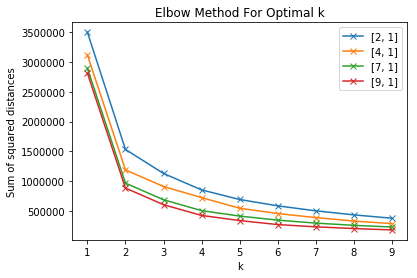

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for c in bst_comb:
    tocluster = pd.DataFrame(ps[c])
    Ks = range(1, 10)
    km = [KMeans(n_clusters=i) for i in Ks]
    score = [km[i].fit(tocluster).inertia_ for i in range(len(km))]
    #score = [-s for s in score]
    l = 'combination' + str(c)
    plt.plot(Ks,score, 'x-', label=c)
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.legend()
plt.show()
    

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_score = 0
for c in bst_comb:
    tocluster = pd.DataFrame(ps[c])
    clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
    labels = clusterer.labels_
    s = silhouette_score(tocluster,labels, metric='euclidean')
    if s>max_score:
        max_score = s
        bst_combination = c

print('best score:',max_score)
print('best combination:',bst_combination)



best score: 0.7241525283660811
best combination: [9, 1]


Best silhoutte score for k = 4 appears for combination (1,9)

### Generating clusters for best k and combination

In [29]:
#Filtering Datasets
tocluster2 = pd.DataFrame(ps[[9,1]])
#tocluster2.columns = ['9','1']
print (tocluster2.shape)
print (tocluster2.head())
tocluster2.describe()

(2500, 2)
           9          1
0  -6.480266   0.356676
1  -2.319482  -4.034460
2   0.400541   1.401625
3   0.239284  -1.149522
4 -12.822913 -25.111308


,9,1
count,2.500000e+03,2.500000e+03
mean,-9.618306e-16,1.881162e-16
std,7.735045e+00,3.264063e+01
min,-7.596056e+01,-1.509157e+02
25%,-1.240549e+00,-3.128212e+00
50%,4.532601e-01,1.716585e+00
75%,1.996913e+00,3.897330e+00
max,1.295725e+02,1.389279e+03


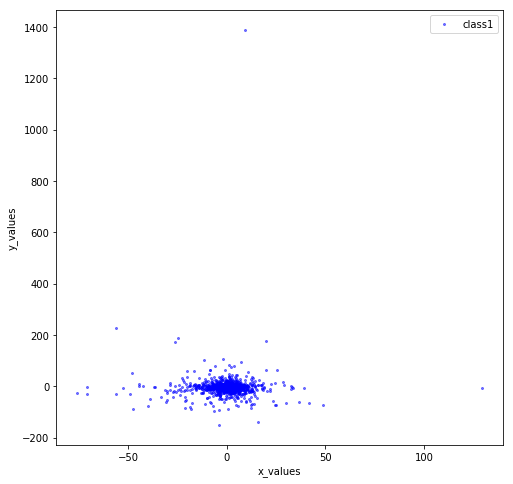

In [30]:
fig = plt.figure(figsize=(8,8))
plt.plot(tocluster2[9], tocluster2[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
# axes = plt.gca()
# axes.set_xlim([-100,100])
# axes.set_ylim([-200,500])
plt.legend()
plt.show()

In [31]:
#outlier treatment
def replace(group):
    mean, std = group.mean(), group.std()
    outliers = (group - mean).abs() > 3*std
    group[outliers] = mean
    return group

tocluster2.transform(replace)

print(tocluster2.shape)
tocluster.describe()


(2500, 2)


,9,1
count,2.500000e+03,2.500000e+03
mean,-9.618306e-16,1.881162e-16
std,7.735045e+00,3.264063e+01
min,-7.596056e+01,-1.509157e+02
25%,-1.240549e+00,-3.128212e+00
50%,4.532601e-01,1.716585e+00
75%,1.996913e+00,3.897330e+00
max,1.295725e+02,1.389279e+03


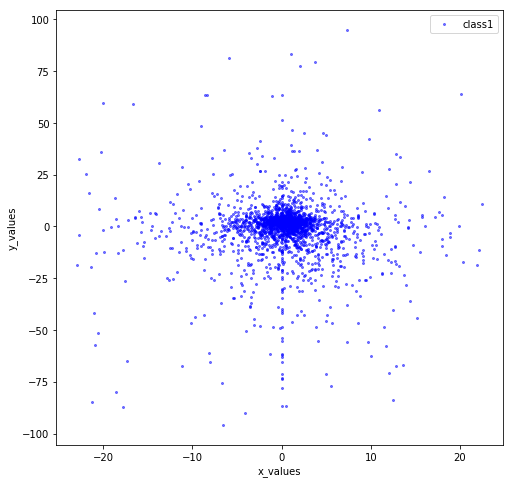

In [32]:
fig = plt.figure(figsize=(8,8))
plt.plot(tocluster2[9], tocluster2[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
# axes = plt.gca()
# axes.set_xlim([-100,100])
# axes.set_ylim([-200,500])
plt.legend()
plt.show()

In [33]:
clusterer2 = KMeans(n_clusters=4,random_state=42).fit(tocluster2)
centers = clusterer2.cluster_centers_
c_preds = clusterer2.predict(tocluster2)
print(centers)

[[  0.21681605   2.37095502]
 [  0.95591015 -14.90208084]
 [ -0.73825713 -57.04161907]
 [ -0.25799685  35.62065058]]


In [34]:
print (c_preds[0:100])

[0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 3 0 0 2 0 2 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 3 0 0 0 0 1 3 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0]


Here is how our clusters appear

['orange', 'orange', 'orange', 'orange', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange']


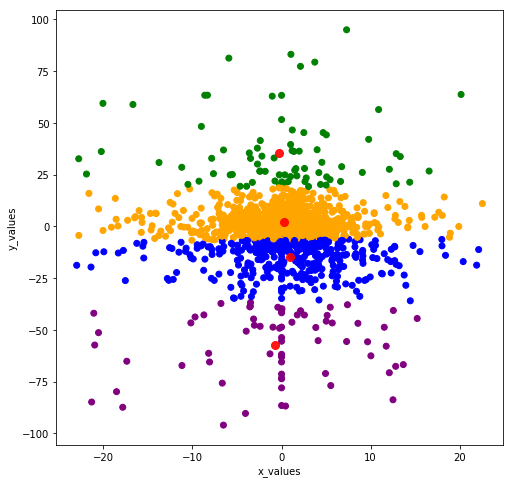

In [35]:
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster2[9],tocluster2[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
#plt.legend()
plt.show()

In [36]:
clust_aisle = cust_aisle.copy()
clust_aisle['cluster'] = c_preds
# clust_aisle['user_id'] = clust_aisle.index
#clust_aisle = clust_aisle.reset_index(drop=True)
clust_aisle.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
284,0,9,0,0,34,2,10,0,0,0,0,0,0,0,0,7,0,3,0,0,16,20,0,0,11,4,1,0,0,3,0,0,6,13,0,0,1,0,0,0,...,0,0,0,15,0,7,3,0,0,4,0,0,0,0,0,0,0,0,1,0,1,5,1,26,16,0,0,2,0,1,1,8,1,0,0,0,0,0,17,0
293,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,7,0,0,0,2,0,0,1,0,1,2,1,0,0,0,0,3,0,0,...,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2,4,9,0,0,1,0,0,3,0,4,0,0,2,4,0,0,0
319,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,...,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,1,0
358,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0
432,0,2,0,0,0,0,1,0,0,0,0,36,1,0,2,4,0,3,26,0,4,5,1,0,1,9,3,0,0,0,5,0,2,0,0,0,0,1,0,0,...,2,0,0,11,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,8,2,0,6,0,9,22,0,0,0,0,1,75,0,3,1
490,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502,0,0,0,0,0,0,1,0,0,0,0,7,0,0,0,0,0,3,0,0,5,1,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,...,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,6,2,0,0,0,4,1,0,1,0,0,0,5,0,15,0
514,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0
519,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


(2500, 135)


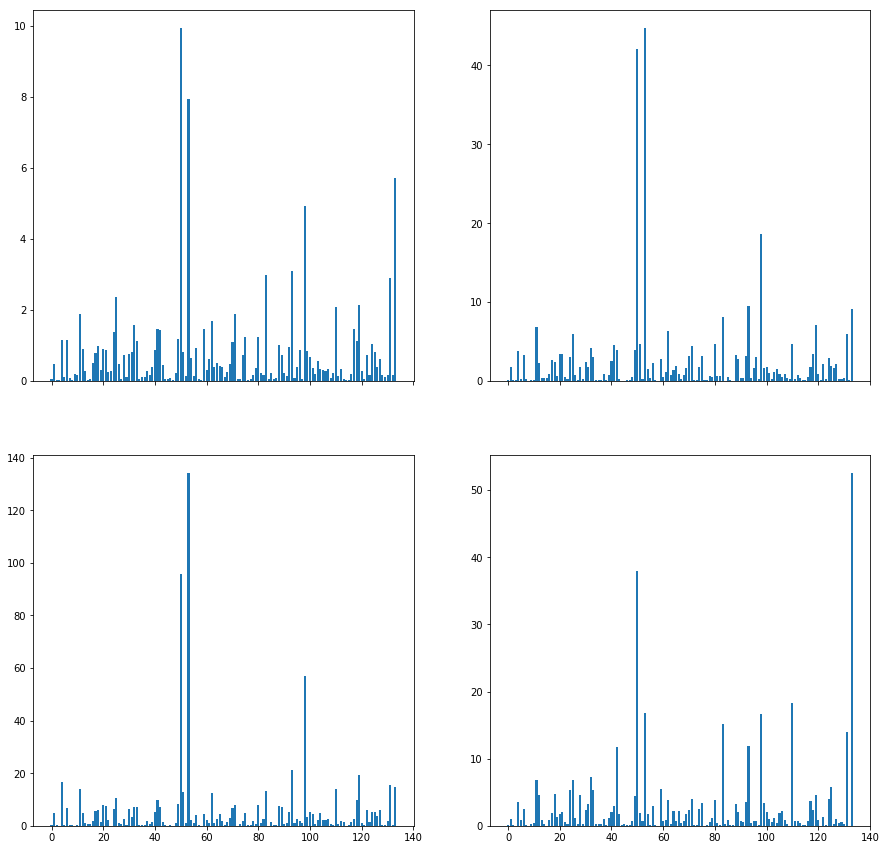

In [37]:
#Top Products for each cluster
print (clust_aisle.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_aisle[clust_aisle['cluster']==0])

c0 = clust_aisle[clust_aisle['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_aisle.drop('cluster',axis=1).columns)),c0)
c1 = clust_aisle[clust_aisle['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_aisle.drop('cluster',axis=1).columns)),c1)
c2 = clust_aisle[clust_aisle['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_aisle.drop('cluster',axis=1).columns)),c2)
c3 = clust_aisle[clust_aisle['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_aisle.drop('cluster',axis=1).columns)),c3)
plt.show()

Finding out the top 5 aisles for each cluster

In [38]:
#Cluster 0 
cluster0_df = pd.DataFrame(c0)
cluster0_df['aisle'] = cluster0_df.index
cluster0_df = cluster0_df.reset_index(drop=True)
cluster0_df['cluster'] = 0
cluster0_df.columns = ['imp','aisle','cluster']
cluster0_df = cluster0_df.sort_values('imp', ascending=False)
cluster0_df  = cluster0_df[['cluster','aisle']]
cluster0_df = cluster0_df.iloc[0:5]
cluster0_df['aisle_n'] = ['aisle1','aisle2','aisle3','aisle4','aisle5']
cluster0_df = cluster0_df.pivot(index='cluster', columns='aisle_n', values='aisle')
#cluster0_df['cluster'] = cluster0_df.index
#cluster0_df = cluster0_df.reset_index(drop=True)
cluster0_df

aisle_n,aisle1,aisle2,aisle3,aisle4,aisle5
cluster,,,,,
0,fresh fruits,fresh vegetables,yogurt,packaged vegetables fruits,packaged cheese


In [39]:
#Cluster 1 
cluster1_df = pd.DataFrame(c1)
cluster1_df['aisle'] = cluster1_df.index
cluster1_df = cluster1_df.reset_index(drop=True)
cluster1_df['cluster'] = 1
cluster1_df.columns = ['imp','aisle','cluster']
cluster1_df = cluster1_df.sort_values('imp', ascending=False)
cluster1_df  = cluster1_df[['cluster','aisle']]
cluster1_df = cluster1_df.iloc[0:5]
cluster1_df['aisle_n'] = ['aisle1','aisle2','aisle3','aisle4','aisle5']
cluster1_df = cluster1_df.pivot(index='cluster', columns='aisle_n', values='aisle')
#cluster1_df['cluster'] = cluster1_df.index
#cluster1_df = cluster1_df.reset_index(drop=True)
cluster1_df

aisle_n,aisle1,aisle2,aisle3,aisle4,aisle5
cluster,,,,,
1,fresh vegetables,fresh fruits,packaged vegetables fruits,packaged cheese,yogurt


In [40]:
#Cluster 2 
cluster2_df = pd.DataFrame(c2)
cluster2_df['aisle'] = cluster2_df.index
cluster2_df = cluster2_df.reset_index(drop=True)
cluster2_df['cluster'] = 2
cluster2_df.columns = ['imp','aisle','cluster']
cluster2_df = cluster2_df.sort_values('imp', ascending=False)
cluster2_df  = cluster2_df[['cluster','aisle']]
cluster2_df = cluster2_df.iloc[0:5]
cluster2_df['aisle_n'] = ['aisle1','aisle2','aisle3','aisle4','aisle5']
cluster2_df = cluster2_df.pivot(index='cluster', columns='aisle_n', values='aisle')
#cluster2_df['cluster'] = cluster2_df.index
#cluster2_df = cluster2_df.reset_index(drop=True)
cluster2_df

aisle_n,aisle1,aisle2,aisle3,aisle4,aisle5
cluster,,,,,
2,fresh vegetables,fresh fruits,packaged vegetables fruits,packaged cheese,soy lactosefree


In [41]:
#Cluster 3 
cluster3_df = pd.DataFrame(c3)
cluster3_df['aisle'] = cluster3_df.index
cluster3_df = cluster3_df.reset_index(drop=True)
cluster3_df['cluster'] = 3
cluster3_df.columns = ['imp','aisle','cluster']
cluster3_df = cluster3_df.sort_values('imp', ascending=False)
cluster3_df  = cluster3_df[['cluster','aisle']]
cluster3_df = cluster3_df.iloc[0:5]
cluster3_df['aisle_n'] = ['aisle1','aisle2','aisle3','aisle4','aisle5']
cluster3_df = cluster3_df.pivot(index='cluster', columns='aisle_n', values='aisle')
#cluster3_df['cluster'] = cluster3_df.index
#cluster3_df = cluster3_df.reset_index(drop=True)
cluster3_df

aisle_n,aisle1,aisle2,aisle3,aisle4,aisle5
cluster,,,,,
3,yogurt,fresh fruits,refrigerated,fresh vegetables,packaged vegetables fruits


In [42]:
cluster_df = pd.concat([cluster0_df,cluster1_df,cluster2_df,cluster3_df])
cluster_df['cluster'] = cluster_df.index
cluster_df = cluster_df.reset_index(drop=True)
cluster_df

aisle_n,aisle1,aisle2,aisle3,aisle4,aisle5,cluster
0,fresh fruits,fresh vegetables,yogurt,packaged vegetables fruits,packaged cheese,0
1,fresh vegetables,fresh fruits,packaged vegetables fruits,packaged cheese,yogurt,1
2,fresh vegetables,fresh fruits,packaged vegetables fruits,packaged cheese,soy lactosefree,2
3,yogurt,fresh fruits,refrigerated,fresh vegetables,packaged vegetables fruits,3


In [43]:
clust_aisle['user_id'] = clust_aisle.index
clust_aisle = clust_aisle.reset_index(drop=True)
clust_aisle.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster,user_id
0,0,9,0,0,34,2,10,0,0,0,0,0,0,0,0,7,0,3,0,0,16,20,0,0,11,4,1,0,0,3,0,0,6,13,0,0,1,0,0,0,...,0,0,15,0,7,3,0,0,4,0,0,0,0,0,0,0,0,1,0,1,5,1,26,16,0,0,2,0,1,1,8,1,0,0,0,0,0,17,0,284
1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,7,0,0,0,2,0,0,1,0,1,2,1,0,0,0,0,3,0,0,...,0,0,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2,4,9,0,0,1,0,0,3,0,4,0,0,2,4,0,0,0,293
2,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,...,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,1,0,319
3,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,358
4,0,2,0,0,0,0,1,0,0,0,0,36,1,0,2,4,0,3,26,0,4,5,1,0,1,9,3,0,0,0,5,0,2,0,0,0,0,1,0,0,...,0,0,11,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,8,2,0,6,0,9,22,0,0,0,0,1,75,0,3,1,432


In [44]:
user_cluster = clust_aisle.join(cluster_df, on='cluster', rsuffix='_')
user_cluster = user_cluster[['user_id','cluster','aisle1','aisle2','aisle3','aisle4','aisle5']]
user_cluster.head()

,user_id,cluster,aisle1,aisle2,aisle3,aisle4,aisle5
0,284,0,fresh fruits,fresh vegetables,yogurt,packaged vegetables fruits,packaged cheese
1,293,0,fresh fruits,fresh vegetables,yogurt,packaged vegetables fruits,packaged cheese
2,319,0,fresh fruits,fresh vegetables,yogurt,packaged vegetables fruits,packaged cheese
3,358,0,fresh fruits,fresh vegetables,yogurt,packaged vegetables fruits,packaged cheese
4,432,1,fresh vegetables,fresh fruits,packaged vegetables fruits,packaged cheese,yogurt


In [45]:
user_cluster_prod = user_cluster.merge(top_prod_aisle, left_on='aisle1', right_on='aisle', how='left').merge(top_prod_aisle, left_on='aisle2', right_on='aisle', how='left').merge(top_prod_aisle, left_on='aisle3', right_on='aisle', how='left').merge(top_prod_aisle, left_on='aisle4', right_on='aisle', how='left').merge(top_prod_aisle, left_on='aisle5', right_on='aisle', how='left')
user_cluster_prod = user_cluster_prod.iloc[:,[0,1,2,8,3,10,4,12,5,14,6,16]]
user_cluster_prod.columns = ['user_id', 'cluster', 'aisle1', 'product1', 'aisle2',
       'product2', 'aisle3', 'product3', 'aisle4',
       'product4', 'aisle5', 'product5']
user_cluster_prod

,user_id,cluster,aisle1,product1,aisle2,product2,aisle3,product3,aisle4,product4,aisle5,product5
0,284,0,fresh fruits,Banana,fresh vegetables,Organic Yellow Onion,yogurt,Total 2% with Strawberry Lowfat Greek Strained...,packaged vegetables fruits,Organic Baby Spinach,packaged cheese,Organic Whole String Cheese
1,293,0,fresh fruits,Banana,fresh vegetables,Organic Yellow Onion,yogurt,Total 2% with Strawberry Lowfat Greek Strained...,packaged vegetables fruits,Organic Baby Spinach,packaged cheese,Organic Whole String Cheese
2,319,0,fresh fruits,Banana,fresh vegetables,Organic Yellow Onion,yogurt,Total 2% with Strawberry Lowfat Greek Strained...,packaged vegetables fruits,Organic Baby Spinach,packaged cheese,Organic Whole String Cheese
3,358,0,fresh fruits,Banana,fresh vegetables,Organic Yellow Onion,yogurt,Total 2% with Strawberry Lowfat Greek Strained...,packaged vegetables fruits,Organic Baby Spinach,packaged cheese,Organic Whole String Cheese
4,432,1,fresh vegetables,Organic Yellow Onion,fresh fruits,Banana,packaged vegetables fruits,Organic Baby Spinach,packaged cheese,Organic Whole String Cheese,yogurt,Total 2% with Strawberry Lowfat Greek Strained...
5,490,0,fresh fruits,Banana,fresh vegetables,Organic Yellow Onion,yogurt,Total 2% with Strawberry Lowfat Greek Strained...,packaged vegetables fruits,Organic Baby Spinach,packaged cheese,Organic Whole String Cheese
6,502,0,fresh fruits,Banana,fresh vegetables,Organic Yellow Onion,yogurt,Total 2% with Strawberry Lowfat Greek Strained...,packaged vegetables fruits,Organic Baby Spinach,packaged cheese,Organic Whole String Cheese
7,514,0,fresh fruits,Banana,fresh vegetables,Organic Yellow Onion,yogurt,Total 2% with Strawberry Lowfat Greek Strained...,packaged vegetables fruits,Organic Baby Spinach,packaged cheese,Organic Whole String Cheese
8,519,0,fresh fruits,Banana,fresh vegetables,Organic Yellow Onion,yogurt,Total 2% with Strawberry Lowfat Greek Strained...,packaged vegetables fruits,Organic Baby Spinach,packaged cheese,Organic Whole String Cheese
9,620,0,fresh fruits,Banana,fresh vegetables,Organic Yellow Onion,yogurt,Total 2% with Strawberry Lowfat Greek Strained...,packaged vegetables fruits,Organic Baby Spinach,packaged cheese,Organic Whole String Cheese


In [46]:
user_cluster_prod.to_csv('user_top5_aisle_product.csv')

Let's check out what are the top 10 goods bought by people of each cluster. We are going to rely first on the absolute data and then on a percentage among the top 8 products for each cluster.

In [47]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     9.943003
fresh vegetables                 7.956743
yogurt                           5.709924
packaged vegetables fruits       4.931298
packaged cheese                  3.112977
milk                             2.988804
water seltzer sparkling water    2.893639
chips pretzels                   2.362850
soy lactosefree                  2.132824
refrigerated                     2.090076
dtype: float64

In [48]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh vegetables              44.742188
fresh fruits                  42.104167
packaged vegetables fruits    18.596354
packaged cheese                9.531250
yogurt                         9.177083
milk                           8.179688
soy lactosefree                7.164062
bread                          6.830729
frozen produce                 6.302083
chips pretzels                 5.971354
dtype: float64

In [49]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 134.246377
fresh fruits                      95.898551
packaged vegetables fruits        57.072464
packaged cheese                   21.347826
soy lactosefree                   19.420290
baby food formula                 16.623188
water seltzer sparkling water     15.333333
yogurt                            14.898551
bread                             14.000000
refrigerated                      13.898551
dtype: float64

In [50]:
c3.sort_values(ascending=False)[0:10]

aisle
yogurt                           52.573171
fresh fruits                     37.878049
refrigerated                     18.292683
fresh vegetables                 16.756098
packaged vegetables fruits       16.621951
milk                             15.146341
water seltzer sparkling water    14.024390
packaged cheese                  11.890244
energy granola bars              11.719512
crackers                          7.195122
dtype: float64

### Inference

* fresh fruits                     
* fresh vegetables                 
* packaged vegetables fruits       
* yogurt                           
* packaged cheese                   
* milk                              
* water seltzer sparkling water     
* chips pretzels                    

are products which are genereically bought by the majority of the customers.

What we can inspect here is if clusters differ in quantities and proportions, with respect of these goods, or if a cluster is characterized by some goods not included in this list. For instance we can already see cluster 3 is characterized by 'Baby Food Formula' product which is a significant difference with respect to the other clusters and cluster 4 is characterized by 'energy granola bars'

In [51]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,9.943003,7.956743,4.931298,5.709924,3.112977,2.988804,2.893639,2.362850
1,42.104167,44.742188,18.596354,9.177083,9.531250,8.179688,5.919271,5.971354
2,95.898551,134.246377,57.072464,14.898551,21.347826,13.347826,15.333333,10.420290
3,37.878049,16.756098,16.621951,52.573171,11.890244,15.146341,14.024390,6.768293


The following table depicts the percentage these goods with respect to the other top 8 in each cluster. It is easy some interesting differences among the clusters. 

It seems people of cluster 1 buy more fresh vegetables than the other clusters. As shown by absolute data, Cluster 2 is also the cluster including those customers buying far more goods than any others.

People of cluster 3 buy more yogurt than people of the other clusters.

Absolute Data shows us People of cluster 3 buy a Lot of 'Baby Food Formula' which not even listed in the top 8 products but mainly characterize this cluster. Coherently (I think) with this observation they buy more milk than the others.

In [52]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,24.920283,19.942093,12.359379,14.310859,7.802097,7.490880,7.252366,5.922043
1,29.194128,31.023275,12.894314,6.363193,6.608765,5.671620,4.104296,4.140409
2,26.450014,37.026822,15.741296,4.109206,5.887996,3.681497,4.229124,2.874046
3,22.065928,9.761296,9.683149,30.626598,6.926684,8.823529,8.169935,3.942882


Checking 10th to 15th most bought products for each cluster which will not include the generic products (i.e. vegetables, fruits, water, etc.) bought by anyone.

In [53]:
c0.sort_values(ascending=False)[10:15]

aisle
bread             1.900763
ice cream ice     1.882952
frozen produce    1.687532
crackers          1.579135
soft drinks       1.475318
dtype: float64

In [54]:
c1.sort_values(ascending=False)[10:15]

aisle
water seltzer sparkling water    5.919271
refrigerated                     4.697917
lunch meat                       4.671875
fresh herbs                      4.661458
eggs                             4.565104
dtype: float64

In [55]:
c2.sort_values(ascending=False)[10:15]

aisle
milk              13.347826
fresh herbs       13.014493
frozen produce    12.449275
chips pretzels    10.420290
eggs               9.927536
dtype: float64

In [56]:
c3.sort_values(ascending=False)[10:15]

aisle
bread             6.829268
chips pretzels    6.768293
tea               5.841463
frozen meals      5.487805
cereal            5.390244
dtype: float64

We can see a lot of different and distinct products for each cluster after checking for top 10 to 15 products in each cluster.